Distributed matching on a graph

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import time
seed = 42
random.seed(seed)

In [2]:
def generate_graph(n,m):
    return nx.gnm_random_graph(n,m,seed)

In [3]:
def divide_edges(graph, nMachines):
    edges = list(graph.edges())
    random.shuffle(edges)
    edges_per_set = len(edges) // nMachines
    edge_sets = []
    j = 0
    for i in range(0, nMachines):
        edge_sets.append(edges[j:j+edges_per_set])
        j = j + edges_per_set

    for i in range(j, len(edges)):
        edge_sets[i % nMachines].append(edges[i])

    return edge_sets

In [4]:
def maximal_matching(edges):
    matching_count = 0
    matching_edges = []
    matched_vertices = []
    
    # Iterate through all edges in the graph
    for edge in edges:
        u, v = edge

        # Check if neither endpoint is already in the matching
        if u not in matched_vertices and v not in matched_vertices:
            # Add the edge to the matching
            matching_edges.append((u, v))
            matched_vertices.append(u)
            matched_vertices.append(v)
            matching_count += 1

    return matching_count, matching_edges, matched_vertices

In [5]:
def slave_machine_mark_edges(edges_count, edge_sets, eta):
    start_time = time.time()
    marked_edges = []
    prob = eta/(2 * edges_count)
    for edge_set in edge_sets:
        for edge in edge_set:
            if random.random() >= prob:
                marked_edges.append(edge)
    end_time = time.time()
    return marked_edges, (end_time - start_time)

In [6]:
def slave_machine_discard_edges(edge_sets, matched_vertices):
    start_time = time.time()
    updated_edge_sets = []
    for edge_set in edge_sets:
        filtered_edges = []
        for edge in edge_set:
            u, v = edge
            if u not in matched_vertices and v not in matched_vertices:
                filtered_edges.append(edge)
        updated_edge_sets.append(filtered_edges)
    end_time = time.time()
    return updated_edge_sets, (end_time - start_time)

In [7]:
def master_maximal_matching(marked_edges):
    return maximal_matching(marked_edges)

In [8]:
def distributed_matching(edge_sets, eta, epsilon, nMachines):
    
    total_matching_count = 0
    total_latency = 0

    while True:
        
        edges_count = sum(len(edge_set) for edge_set in edge_sets)
        
        if edges_count == 0:
            break
            
        elif edges_count <= eta:

            start_time = time.time()
            marked_edges = []
            for edge_set in edge_sets:
                for edge in edge_set:
                    marked_edges.append(edge)
                    
            matching_count, matching_edges, matched_vertices = master_maximal_matching(marked_edges)
            end_time = time.time()
            
            total_matching_count += matching_count
            total_latency += (end_time - start_time)
            
            break
            
        else:
            
            #Marking edges on all machines
            marked_edges, mark_latency = slave_machine_mark_edges(edges_count, edge_sets, eta)
            #Dividing total time taken by all slave machines by number of Machines for parallel effect
            total_latency += (mark_latency/nMachines)
            
            #Sending it to Machine 0 and computing maximal matching
            start_time = time.time()
            matching_count, matching_edges, matched_vertices = master_maximal_matching(marked_edges)
            end_time = time.time()
            total_latency += (end_time - start_time)
            
            #Discarding any local edge with vertices in maximal matching
            edge_sets, discard_latency = slave_machine_discard_edges(edge_sets, matched_vertices)
            #Dividing total time taken by all slave machines by number of Machines for parallel effect
            total_latency += (discard_latency/nMachines)

            total_matching_count += matching_count
    
    return total_matching_count, total_latency

In [16]:
def print_results(distributed_latencies_nValues, nValues, eValues, singleMachine_latencies_nValues, 
                  distributed_matching_counts, single_machine_counts, distributed_latencies, epsilons_Arr, n, m, distributed_latencies_nMachines, nMachines_Arr):

    plt.figure(0)
    
    plt.plot(nValues, singleMachine_latencies_nValues, marker='o', label='Single Machine Matching')
    plt.plot(nValues, distributed_latencies_nValues, marker='o', label='Distributed Matching')
    
    plt.xlabel('Different Values of Vertices and Edges (V,E)')
    plt.ylabel('Latency (s)')
    plt.title(f'Distributed Matching vs Single Machine Matching')
    plt.legend()

    pairs = [(n, m) for n, m in zip(nValues, eValues)]
    plt.xticks(nValues, [f'({n}, {m})' for n, m in pairs])

    plt.figure(1)
    
    bar_width = 0.35
    index = range(len(pairs))

    bars1 = plt.bar(index, distributed_matching_counts, bar_width, label='Distributed Matching')
    bars2 = plt.bar([i + bar_width for i in index], single_machine_counts, bar_width, label='Single Machine Matching')

    plt.xlabel('Different Values of Vertices and Edges (V,E)')
    plt.ylabel('Edges in Maximal Matching')
    plt.title('Maximal Matching Counts Comparison')
    plt.xticks([i + bar_width / 2 for i in index], [f'({n}, {m})' for n, m in pairs])
    plt.legend()

    # Add values on top of the bars
    for bar1, bar2 in zip(bars1, bars2):
        plt.text(bar1.get_x() + bar1.get_width() / 2 - 0.15, bar1.get_height() + 0.2, str(bar1.get_height()), ha='center')
        plt.text(bar2.get_x() + bar2.get_width() / 2 + 0.15, bar2.get_height() + 0.2, str(bar2.get_height()), ha='center')

    plt.figure(2)
    plt.plot(epsilons_Arr, distributed_latencies, marker='o', label='Distributed Matching')
    
    plt.xlabel('Epsilon Values')
    plt.ylabel('Latency (s)')
    plt.title(f'Distributed Matching |V| = {n} |E| = {m}')
    plt.legend()

    plt.figure(3)
    plt.plot(nMachines_Arr, distributed_latencies_nMachines, marker='o', label='Distributed Matching')
    
    plt.xlabel('Number of Machine')
    plt.ylabel('Latency (s)')
    plt.title(f'Distributed Matching |V| = {n} |E| = {m}')
    plt.legend()
    
    plt.show()

In [19]:
def main():
    
    #First Test
    nValues = [500, 1000, 1500, 2000]
    eValues = []
    distributed_latencies_nValues = []
    singleMachine_latencies_nValues = []
    distributed_matching_counts = []
    single_machine_counts = []
    for v in nValues:
        graph = nx.erdos_renyi_graph(v, 0.2, seed=seed, directed=False)        
        edgeList = list(graph.edges())
        e = len(edgeList)
        eValues.append(e)
        nMachines = math.floor(e/v)
        edge_sets = divide_edges(graph, nMachines)
        epsilon = 0.2
        eta = math.floor(v ** (1+epsilon))
        distributed_maximal_matching_count, distributed_latency = distributed_matching(edge_sets, eta, epsilon, nMachines)
        distributed_latencies_nValues.append(distributed_latency)
        distributed_matching_counts.append(distributed_maximal_matching_count)

        singleMachine_start_time = time.time()
        singleMachine_maximal_matching_count = maximal_matching(edgeList)[0]
        singleMachine_end_time = time.time()
        singleMachine_latency = singleMachine_end_time - singleMachine_start_time
        singleMachine_latencies_nValues.append(singleMachine_latency)
        single_machine_counts.append(singleMachine_maximal_matching_count)

    #Second Test
    n = 2000
    graph = nx.erdos_renyi_graph(n, 0.2, seed=seed, directed=False)        
    edgeList = list(graph.edges())
    m = len(edgeList)
    nMachines = math.floor(m/n)
    edge_sets = divide_edges(graph, nMachines)

    epsilons_Arr = [0.01, 0.05, 0.1, 0.5, 0.9]
    distributed_latencies = []
    
    for epsilon in epsilons_Arr:
        eta = math.floor(n ** (1+epsilon))
        distributed_maximal_matching_count, distributed_latency = distributed_matching(edge_sets, eta, epsilon, nMachines)
        distributed_latencies.append(distributed_latency)

    #Third Test
    v = 2000
    graph = nx.erdos_renyi_graph(v, 0.2, seed=seed, directed=False)        
    edgeList = list(graph.edges())
    e = len(edgeList)
    nMachines_Arr = [50, 100, 150, 200]
    eta = math.floor(v ** (1+epsilon))
    epsilons = 0.01
    distributed_latencies_nMachines = []
    
    for nMachines in nMachines_Arr:
        edge_sets = divide_edges(graph, nMachines)
        distributed_maximal_matching_count, distributed_latency = distributed_matching(edge_sets, eta, epsilon, nMachines)
        distributed_latencies_nMachines.append(distributed_latency)

    print_results(distributed_latencies_nValues, nValues, eValues, singleMachine_latencies_nValues, 
                  distributed_matching_counts, single_machine_counts, distributed_latencies, epsilons_Arr, n, m, distributed_latencies_nMachines, nMachines_Arr)

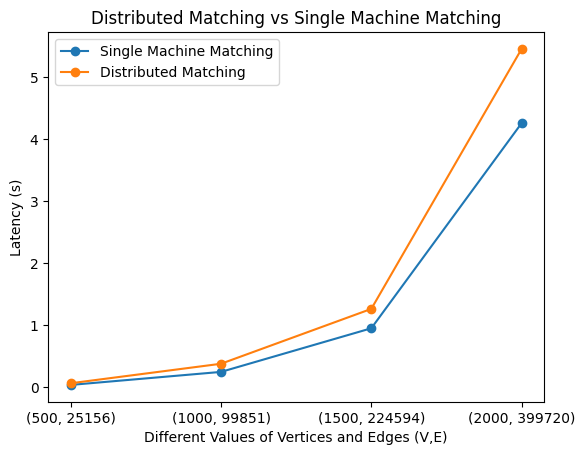

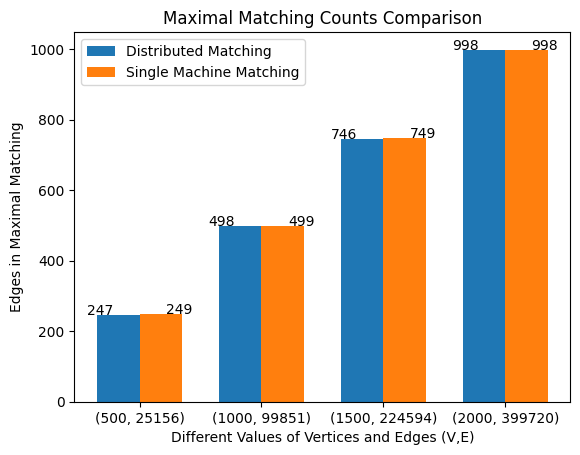

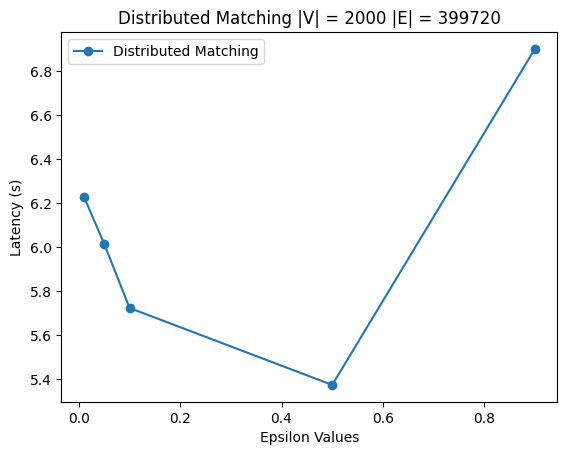

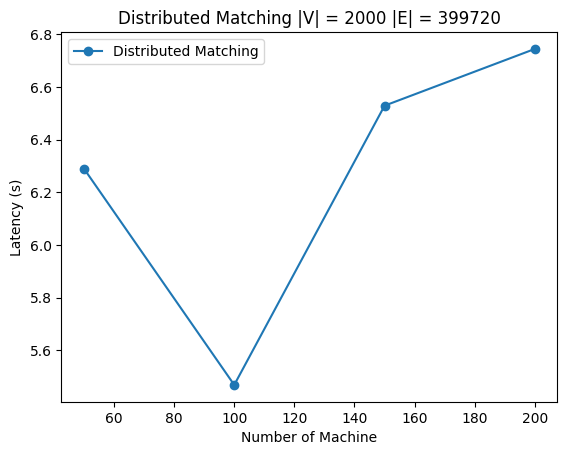

In [20]:
if __name__ == "__main__":
    main()